In [1]:
from scipy.signal import butter, filtfilt, find_peaks, freqz, sosfilt
import glob
import os
from fnmatch import fnmatch
import h5py
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import sys 
import multiprocessing
from multiprocessing import Pool
import time

sys.path.insert(0, '../../drlib')
import drlib as dr


ModuleNotFoundError: No module named 'h5py'

In [ ]:
class avgSpec:
    '''
    Inputs:
        fileList(list):
        List of file names of form `data_<n>.h5`

        dataDir(string): 
        Realitive path to data directory

        numProc(int):
        Number of processes to open data files.

    Methods:
        avgMesDataAll: worker. averages together all measData in a single data file
        compAvgAll: calls avgMesData in parallel
    '''
    
    def __init__(self,
        fileList,
        dataDir,
        numProc = 28,
        verbose = False):

        self.fileList = fileList
        self.dataDir = dataDir
        self.numProc = numProc
        self.verbose = verbose

        self.antData = np.zeros(2**23)
        self.termData = np.zeros(2**23)
        
        #can pull these out of data files later
        self.startFreq = 0
        self.stopFreq = 300
        numBins = 8388607
        self.freqs = np.linspace(self.startFreq, self.stopFreq, numBins)
   
        self.computeAvgAll()

    
    
    def avgMesDataAll(self, aFile):
        '''
        Worker function to open a data file and average ALL mesData. Called by mProcAvgAll

        Parameters:
            self.fileList (list of strings): list of file names to be averaged 
            self.dataDir (str): Location of files. Realitive path.

        Returns:
            antData (1D np arr): averaged off spectrum (linear FFT units)
            termData (1D np arr): averaged on spectrum (linear FFT units)
            numAvgInDataFile (int): number of averages in data file.
        '''
        #init some parameters
        antData = np.zeros(2**23)
        termData = np.zeros(2**23)
        numDataSets = 0
        numAvgInDataFile = 0

        #itterate through file list and open h5 files in 'r(ead)' mode
        if self.verbose == True:
            print('ON FILE: ' + str(aFile))
        dataBin = h5py.File(self.dataDir + aFile, 'r') #makes pointer to h5
        numAvgInMesDataSet = int(dataBin.attrs['averages']) #total number of average for dataset
        allKeys = [aKey for aKey in dataBin.keys()] #key is measdata. 16 per dataset

        for aKey in allKeys[:]:
            dataset = pd.read_hdf(dataDir + aFile, key = aKey) #dataframe of ROACH data (check)
        # need to print and look at this
            termData +=  np.asarray(dataset[dataset.keys()[0]]) #term or bicon
            antData += np.asarray(dataset[dataset.keys()[1]]) #the other one
            numDataSets += 1
            numAvgInDataFile += numAvgInMesDataSet

        antData /= numDataSets
        termData /= numDataSets
        
        return antData, termData, numAvgInDataFile

    def avgDataList(self):
        '''
        Parameters:
            self.dataList (list of len=self.fileList): Each element of dataList contains a len=3 tuple
                which contains (antData (arr of len=numBins), 
                                termData (arr of len=numBins), 
                                numAvgInDataFile (int))
        
        Sets:
            self.antData (1D np arr): averaged off spectrum (linear FFT units)
            self.termData (1D np arr): averaged on spectrum (linear FFT units)
        '''
        antData = np.zeros(2**23)
        termData = np.zeros(2**23)
        numDataFiles = 0

        for dataTuple in self.dataList:n long calculations
            antData += dataTuple[0]
            termData += dataTuple[1]
            numDataFiles += 1
        
        self.antData = antData / numDataFiles
        self.termData = termData / numDataFiles
        
    def mProcAvgAll(self):
        '''
        moved this code into computeAvgAll. Delete soon

        Opens all files in fileList. Each process (pool) computes an average spectra
        on ALL of a single data file's measData. Returns linear FFT units.
        
        Parameters:
            self.fileList (list of strings): list of file names to be averaged 
        
        Returns:
            None
        
        Sets:
            self.dataList (list of len=self.fileList): Each element of dataList contains a len=3 tuple
                which contains (antData (arr of len=numBins), 
                                termData (arr of len=numBins), 
                                numAvgInDataFile (int))
             
        Calls:
            avgMesDataAll(): worker function. Averages together ALL mesData in a data file

         '''


    def computeAvgAll(self):
        '''
        Opens each file in fileList and computes an average of ALL measData in each data file.
        Then averages each of these averages together. 

        Parameters:
            self.fileList (list of strings): list of file names to be averaged

        Returns:
            None

        Sets:
            self.dataList (list of len=self.fileList): Each element of dataList contains a len=3 tuple
                which contains (antData (arr of len=numBins), 
                                termData (arr of len=numBins), 
                                numAvgInDataFile (int))
             
        Calls:
            avgMesDataAll(): worker function. Averages together ALL mesData in a data file
        '''
        tStart = time.time()

        print('Starting to open', len(self.fileList),
                'files and avgerage mesData with', self.numProc, 'processes')
        if __name__ == '__main__':
            #Multiprocessing. Each process (pool) computes an 
            #average spectra on ALL of a single data file's measData.
            pool = Pool(processes = self.numProc)
            self.dataList = pool.map(self.avgMesDataAll, self.fileList)

            #Calculate total number of FFTs in returned spectra. Each data 
            #file returns number of FFTs in dataList[data file index][2]  
            self.totalNumAvg = 0
            for runningAverages in self.dataList:
                self.totalNumAvg += runningAverages[2]
        tMesData = time.time()

        #print('Done opening. Now averaging dataFile arrays together') 
        self.avgDataList()
        tDone = time.time()

        #print('time to open and avg mes data =', tMesData - tStart)
        print('Done. Total time =', tDone - tStart)

             

In [2]:
def mkFileList(dataDir):

	#get list of files in dataDir, pack data*.h5 named files into fileList
	dataDirContents = os.listdir(dataDir)
	fileList = [file for file in dataDirContents if fnmatch(file, 'data*.h5')]
	fileList.sort()
	return fileList
    
dataDir = './data_7_7_22_gitignore/'
fileList = mkFileList(dataDir)

In [2]:
dataDir = '../../../../drBiggerBoy/drData/Data/'
fileList = dr.mkFileList(dataDir)

In [3]:
specAllData = dr.avgSpec(fileList[0:100], dataDir, verbose=True)

Starting to open 100 files and avgerage mesData with 28 processes
ON FILE: data_0.h5
ON FILE: data_1.h5
ON FILE: data_10.h5
ON FILE: data_100.h5
ON FILE: data_101.h5
ON FILE: data_102.h5
ON FILE: data_103.h5
ON FILE: data_104.h5
ON FILE: data_105.h5
ON FILE: data_106.h5
ON FILE: data_107.h5
ON FILE: data_108.h5
ON FILE: data_109.h5
ON FILE: data_11.h5
ON FILE: data_110.h5
ON FILE: data_111.h5
ON FILE: data_112.h5
ON FILE: data_113.h5
ON FILE: data_114.h5
ON FILE: data_115.h5
ON FILE: data_116.h5
ON FILE: data_117.h5
ON FILE: data_118.h5
ON FILE: data_119.h5
ON FILE: data_12.h5
ON FILE: data_120.h5
ON FILE: data_121.h5
ON FILE: data_122.h5
ON FILE: data_123.h5
ON FILE: data_124.h5
ON FILE: data_125.h5
ON FILE: data_126.h5
ON FILE: data_127.h5
ON FILE: data_128.h5
ON FILE: data_129.h5
ON FILE: data_13.h5
ON FILE: data_130.h5
ON FILE: data_131.h5
ON FILE: data_132.h5
ON FILE: data_133.h5
ON FILE: data_134.h5
ON FILE: data_135.h5
ON FILE: data_136.h5
ON FILE: data_137.h5
ON FILE: data_138.

In [4]:
spec102 = dr.avgSpec(fileList[102:103], dataDir)
spec103 = dr.avgSpec(fileList[103:104], dataDir)
spec104 = dr.avgSpec(fileList[104:105], dataDir)
spec105 = dr.avgSpec(fileList[105:106], dataDir)
spec106 = dr.avgSpec(fileList[106:107], dataDir)
spec107 = dr.avgSpec(fileList[107:108], dataDir)
spec108 = dr.avgSpec(fileList[108:109], dataDir)
spec109 = dr.avgSpec(fileList[109:110], dataDir)
spec110 = dr.avgSpec(fileList[110:111], dataDir)




Starting to open 1 files and avgerage mesData with 28 processes
Done. Total time = 15.190652847290039


'\nspec103 = dr.avgSpec(fileList[103:104], dataDir)\nspec104 = dr.avgSpec(fileList[104:105], dataDir)\nspec105 = dr.avgSpec(fileList[105:106], dataDir)\nspec106 = dr.avgSpec(fileList[106:107], dataDir)\nspec107 = dr.avgSpec(fileList[107:108], dataDir)\nspec108 = dr.avgSpec(fileList[108:109], dataDir)\nspec109 = dr.avgSpec(fileList[109:110], dataDir)\nspec110 = dr.avgSpec(fileList[110:111], dataDir)\n'

In [8]:
spec102to110 = dr.avgSpec(fileList[102:111], dataDir)

Starting to open 9 files and avgerage mesData with 28 processes
Done. Total time = 33.352487325668335


Text(0, 0.5, 'Power (dBm)')

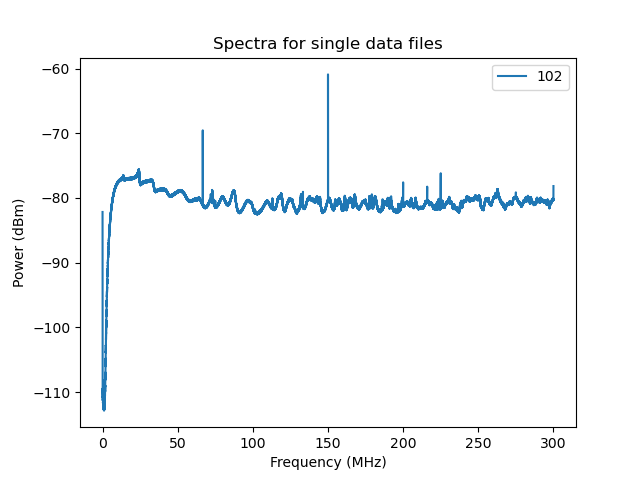

In [5]:
%matplotlib widget

freqs = spec102.freqs
plt.title('Spectra for single data files')
plt.plot(freqs, dr.fft2dBm(spec102.antData[1:]), label = '102')
plt.plot(freqs, dr.fft2dBm(spec103.antData[1:]), label = '103')
plt.plot(freqs, dr.fft2dBm(spec104.antData[1:]), label = '104')
plt.plot(freqs, dr.fft2dBm(spec105.antData[1:]), label = '105', alpha = .8)
plt.plot(freqs, dr.fft2dBm(spec106.antData[1:]), label = '106', alpha = .8)
plt.plot(freqs, dr.fft2dBm(spec107.antData[1:]), label = '107', alpha = .8)
plt.plot(freqs, dr.fft2dBm(spec108.antData[1:]), label = '108', alpha = .8)
plt.plot(freqs, dr.fft2dBm(spec109.antData[1:]), label = '109', alpha = .8)
plt.plot(freqs, dr.fft2dBm(spec110.antData[1:]), label = '110', alpha = .8)

plt.plot(freqs, dr.fft2dBm(spec102to110.antData[1:]), label = '102to110', alpha = .8)

plt.plot(freqs, dr.fft2dBm(spec102.termData[1:]), label = 'Term')


plt.legend(loc = 'upper right')
plt.xlabel("Frequency (MHz)")
plt.ylabel('Power (dBm)')

In [ ]:
spec10Files = avgSpec(fileList[100:110], dataDir)


#takes about 12 seconds on dr2
spec10Files.computeAvgAll()


In [10]:
freqs = specAllData.freqs

In [ ]:
%matplotlib widget
plt.plot(freqs, dr.fft2dBm(specAllData.antData[1:]), 
    label = ('Antenna 18 positions, %i' % specAllData.totalNumAvg ,'avg') )

plt.plot(freqs, dr.fft2dBm(spec102.antData[1:]), 
    label = ('Antenna 1 position, %i' % spec102.totalNumAvg ,'avg') , alpha = 0.6)
#plt.plot(freqs, dr.fft2dBm(spec102to110.antData[1:]), 
    #label = ('Antenna 1 position, %i' % spec1File.totalNumAvg ,'avg') , alpha = 0.6)

plt.legend(loc = 'upper right')
plt.grid()
plt.ylim(-83, -75)

In [ ]:
%matplotlib widget

freqs = specAllData.freqs

plt.title('All Data (18 Positions, %i Averages), Bicon vs Terminator' % specAllData.totalNumAvg)
plt.plot(freqs, fft2dBm(specAllData.antData[1:]), 
    label = 'Bicon')

plt.plot(freqs, fft2dBm(specAllData.termData[1:]), 
    label = 'Terminator' )
#plt.legend()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (dBm)')
plt.grid()

Text(0, 0.5, 'Linear FFT units')

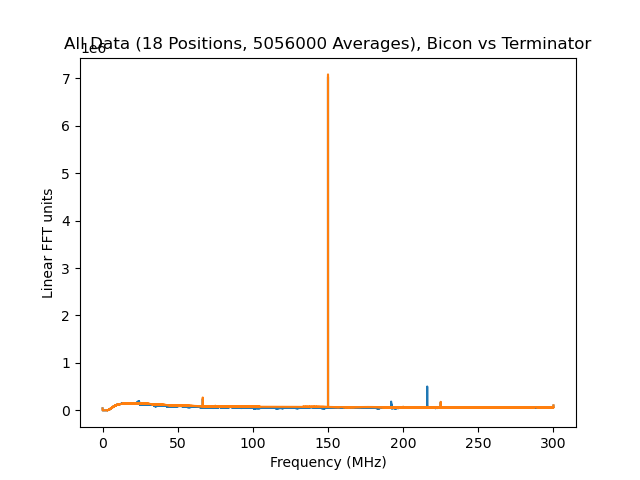

In [12]:
%matplotlib widget

plt.title('All Data (18 Positions, %i Averages), Bicon vs Terminator' % specAllData.totalNumAvg)
plt.plot(freqs, (specAllData.antData[1:]), 
    label = 'Bicon')

plt.plot(freqs, (specAllData.termData[1:]), 
    label = 'Terminator' )
#plt.legend()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Linear FFT units')

In [ ]:
%matplotlib widget

plt.title('All Data (18 Positions, %i Averages), Bicon vs Terminator' % specAllData.totalNumAvg)
plt.plot(freqs, fft2dBm(spec102.antData[1:]), 
    label = '1 file')

plt.plot(freqs, fft2dBm(specAllData.antData[1:]), 
    label = 'All Data',
    alpha = .5 )
#plt.legend()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Linear FFT units')

In [ ]:
%matplotlib widget

plt.title('All Data (18 Positions, %i Averages), Bicon vs Terminator' % specAllData.totalNumAvg)
plt.plot(freqs, fft2dBm(specAllData.termData[1:]), 
    label = '1 file')

plt.plot(freqs, fft2dBm(specAllData.antData[1:]), 
    label = 'All Data',
    alpha = 1 )
#plt.legend()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Linear FFT units')

In [ ]:
spec = avgSpec(fileList[::10], dataDir)
spec.computeAvgAll()

In [ ]:
freqs = spec.freqs

# Sampling rate such that the total amount of data is 1s
fs = len(freqs)

# Cutoff in number of bins
fc = 100

# Normalize the frequency in term of Nyquist
fcNorm = 2./(fc)

# Create a 6th-order Butterworth filter - returns numerator (b) and denominator (a) polynomials of the IIR filter
b, a = butter(6, fcNorm, 'highpass', analog = False)

filteredData = filtfilt(b, a, spec.antData[1:])


In [ ]:
%matplotlib widget
plt.plot(freqs, filteredData)

In [ ]:
#test time to compute with different numbers of processes
def mkFileList(dataDir):

	#get list of files in dataDir, pack data*.h5 named files into fileList
	dataDirContents = os.listdir(dataDir)
	fileList = [file for file in dataDirContents if fnmatch(file, 'data*.h5')]
	fileList.sort()
	return fileList

dataDir = './data_7_7_22_gitignore/'
fileList = mkFileList(dataDir)[0:100]

spec = avgSpec(fileList, dataDir, numProc=32)
spec.computeAvgAll()
print()


spec = avgSpec(fileList, dataDir, numProc=28)
spec.computeAvgAll()
print()

spec = avgSpec(fileList, dataDir, numProc=24)
spec.computeAvgAll()
print()

spec = avgSpec(fileList, dataDir, numProc=20)
spec.computeAvgAll()
print()

spec = avgSpec(fileList, dataDir, numProc=16)
spec.computeAvgAll()
print()

spec = avgSpec(fileList, dataDir, numProc=12)
spec.computeAvgAll()
print()

spec = avgSpec(fileList, dataDir, numProc=8)
spec.computeAvgAll()
print()

spec = avgSpec(fileList, dataDir, numProc=4)
spec.computeAvgAll()
print()

spec.computeAvgAll()

spec = avgSpec(fileList, dataDir, numProc=1, verbose=True)
spec.computeAvgAll()
print()







In [ ]:
spec.avgMesData

In [ ]:
def mkFileList(dataDir):

	#get list of files in dataDir, pack data*.h5 named files into fileList
	dataDirContents = os.listdir(dataDir)
	fileList = [file for file in dataDirContents if fnmatch(file, 'data*.h5')]
	fileList.sort()
	return fileList

def getData(aFile):
	dataDir = './data_7_7_22_gitignore/'
	#init some parameters
	offData = np.zeros(2**23)
	termData = np.zeros(2**23)
	totalSets = 0
	totalAverages = 0


	#itterate through file list and open h5 files in 'r(ead)' mode
	print('ON FILE: ' + str(aFile))
	dataBin = h5py.File(dataDir + aFile, 'r') #makes pointer to h5
	fileAverages = int(dataBin.attrs['averages']) #total number of average for dataset
	allKeys = [aKey for aKey in dataBin.keys()] #key is measdata. 16 per dataset

	for aKey in allKeys[:]:
		print('ON KEY ' + str(aKey))
		dataset = pd.read_hdf(dataDir + aFile, key = aKey) #dataframe of ROACH data (check)
    # need to print and look at this
		offData +=  np.asarray(dataset[dataset.keys()[0]]) #term or bicon
		termData += np.asarray(dataset[dataset.keys()[1]]) #the other one
		totalSets += 1
		totalAverages += fileAverages

	#signal[dBm] = mag^2 [fft units]
	# signal = 10log10(2[preserve power] * data[ADC units] * len(FFT)^2 * 50[Ohms] 1000[mW/W] 
	#also! compute average. Data is sum from prev. line, divide by total sets
	#it is actually faster to do this all in one go because this function is IO limited
	#BUT! there is more averaging that needs to be done so don't go to dBm
	
	#offData = 10.*np.log10(2. * offData / totalSets  / (2**48 * 50. / 1000.))
	#termData = 10.*np.log10(2. * termData / totalSets  / (2**48 * 50. / 1000.))

	offData /= totalSets
	termData /= totalSets
	
	return offData, termData, totalAverages

	
def getDataBen(dataDir):
	fileList = sorted(
		[aFile for aFile in glob.glob(dataDir + 'data*.h5')], 
		key=lambda x: int(x[x.index('data_') + 5: x.index('.h5')])
		)
	print(fileList)



	offData = np.zeros(2**23)
	termData = np.zeros(2**23)

	totalSets = 0
	totalAverages = 0
	for aFile in fileList[:100]:
		print('ON FILE: ' + str(aFile))
		dataBin = h5py.File(aFile, 'r')
		fileAverages = int(dataBin.attrs['averages'])
		allKeys = [aKey for aKey in dataBin.keys()]

		for aKey in allKeys[:]:
			print('ON KEY ' + str(aKey))
			dataset = pd.read_hdf(aFile, key = aKey)

			offData = offData + np.asarray(dataset[dataset.keys()[0]])
			termData = termData + np.asarray(dataset[dataset.keys()[1]])
			totalSets += 1
			totalAverages += fileAverages
	offData = 10.*np.log10(2. * offData / totalSets  / (2**48 * 50. / 1000.))
	termData = 10.*np.log10(2. * termData / totalSets  / (2**48 * 50. / 1000.))


	return offData, termData, totalAverages

def plotTermSigData(fileNameTerm, avgDataBicon, freqs):
	offDataTerm = np.zeros(2**23)
	onDataTerm = np.zeros(2**23)

	totalSets = 0
	print('ON FILE: ' + str(fileNameTerm))
	dataBin = h5py.File(fileNameTerm, 'r')
	allKeys = [aKey for aKey in dataBin.keys()]

	for aKey in allKeys[:]:
		print('ON KEY ' + str(aKey))
		dataset = pd.read_hdf(fileNameTerm, key = aKey)

		offDataTerm = offDataTerm + np.asarray(dataset[dataset.keys()[0]])
		onDataTerm = onDataTerm + np.asarray(dataset[dataset.keys()[1]])
		totalSets += 1

	offDataTerm = 10.*np.log10(2. * offDataTerm / totalSets  / (2**48 * 50. / 1000.))
	onDataTerm = 10.*np.log10(2. * onDataTerm / totalSets  / (2**48 * 50. / 1000.))
	peakIndices = find_peaks(avgDataBicon[1:] - onDataTerm[1:], threshold = 1.75)[0]
	peakVals = np.asarray([(avgDataBicon[1:] - onDataTerm[1:])[x] for x in peakIndices]) 

	plt.xlabel('Frequency (MHz)', labelpad = 15, **label_font)
	plt.ylabel('Ratio (dB)', **label_font)
	#plt.plot(freqs[1:], onDataTerm[1:], alpha = 0.7, label = 'Bicon Sig Gen Off')
	plt.plot(avgDataBicon[1:] - onDataTerm[1:], alpha = 0.7, label = 'Bicon Sig Gen On')
	plt.plot(peakIndices, peakVals, 'r*')

	plt.title('Ratio Bicon, Injected 123.456MHz vs No Injection')
	plt.show()
	#plt.legend(prop = legend_font)
	return peakIndices

In [ ]:
dataDir = './data_7_7_22_gitignore/'
fileList = mkFileList(dataDir)
#print(fileList)

if __name__ == '__main__':
    pool = Pool(processes=24)
    data = pool.map(getData, fileList[0:8])
    #pid, offData, termData, totalAverages = data

In [ ]:
print(np.shape(data))

In [ ]:
data

In [ ]:
termData

In [ ]:
butter(